In [7]:
from brainiak.factoranalysis.tfa import TFA
from brainiak.factoranalysis.htfa import HTFA
import hypertools as hyp
import nilearn as nl
from IPython.display import YouTubeVideo

%matplotlib inline

# Background and overview #

We'll be learning how to create movies of dynamic brain networks using single-subject and multi-subject fMRI data.  After getting the dataset and wrangling it into the proper format, there are three basic steps:
1. Use Hierarchical Topographic Factor Analysis (HTFA) to obtain a set of network "hubs," and the moment-by-moment hub activations.  Model details may be found [here](http://www.biorxiv.org/content/early/2017/02/07/106690).  This creates a simplified version of the full-brain data that is especially useful for computing dynamic network patterns.
1. Use the hub activactions to compute the moment-by-moment connectivity matrix reflected by the data.  We will be using a modified version of Inter-Subject Functional Connectivity (ISFC), which you can read more about [here](https://docs.wixstatic.com/ugd/b75639_92eab30b43284ca0bd163e3daa709eda.pdf).
1. Use [nilearn](http://nilearn.github.io/) and [hypertools](http://hypertools.readthedocs.io/en/latest/) to visualize the results and create pretty animations.

## Experiment ##
We'll be exploring a part of a dataset collected by Uri Hasson's lab.  The experiment had 36 participants listen *Pie Man*, a story told by Jim O'Grady as part of *The Moth* live storytelling event.  You can listen to the story here:

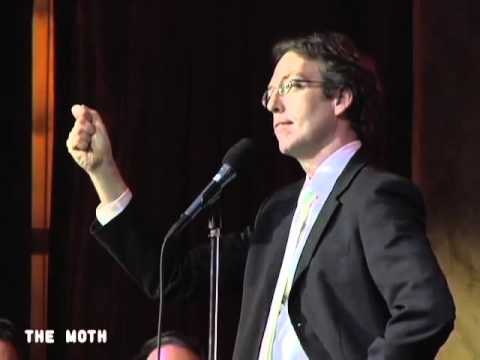

In [9]:
YouTubeVideo('3nZzSUDECLo')

## Data ##
The dataset comprises 36 preprocessed .nii files, and may be downloaded [here](MISSING LINK).  However, in the interest of running the analysis quickly, for this tutorial we're going to be working with just a small part of the dataset: 100 images from each of 5 participants.  This smaller dataset may be downloaded [here](ADD LINK).

### Data formatting: .nii --> matrix format ###
To computing HTFA-derived brain networks, we're going to first convert the .nii files into [CMU format](http://www.cs.cmu.edu/afs/cs/project/theo-73/www/science2008/README-data-documentation.txt), inspired by Tom Mitchell's website for his 2008 Science paper on predicting brain responses to common nouns ([link](http://www.cs.cmu.edu/afs/cs/project/theo-73/www/science2008/data.html)).